# Practical Text Classification With Python and Keras
Imagine you could know the mood of the people on the Internet. Maybe you are not interested in its entirety, but only if people are today happy on your favorite social media platform. After this tutorial, you'll be equipped to do this. While doing this, you will get a grasp of current advancements of (deep) neural networks and how they can be applied to text.

Reading the mood from text with machine learning is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), and it is one of the prominent use cases in text classification. This falls into the very active research field of [natural language processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing). Other common use cases of text classification include detection of spam, auto tagging of customer queries, and categorization of text into defined topics. So how can you do this?

## Choosing a Data Set
Before we start, let's take a look at what data we have. Go ahead and download the data set from the [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from the UCI Machine Learning Repository.

By the way, this repository is a wonderful source for machine learning data sets when you want to try out some algorithms. This data set includes labeled reviews from IMDb, Amazon, and Yelp. Each review is marked with a score of 0 for a negative sentiment or 1 for a positive sentiment.

Extract the folder into a `data` folder and go ahead and load the data with [Pandas](https://pandas.pydata.org/):

In [2]:
import pandas as pd

filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


This looks about right. With this data set, you are able to train a model to predict the sentiment of a sentence. Take a quick moment to think about how you would go about predicting the data.

One way you could do this is to count the frequency of each word in each sentence and tie this count back to the entire set of words in the data set. You would start by taking the data and creating a vocabulary from all the words in all sentences. The collection of texts is also called a corpus in NLP.

The vocabulary in this case is a list of words that occurred in our text where each word has its own index. This enables you to create a vector for a sentence. You would then take the sentence you want to vectorize, and you count each occurrence in the vocabulary. The resulting vector will be with the length of the vocabulary and a count for each word in the vocabulary.

The resulting vector is also called a feature vector. In a feature vector, each dimension can be a numeric or categorical feature, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary. These feature vectors are a crucial piece in data science and machine learning, as the model you want to train depends on them.

Let's quickly illustrate this. Imagine you have the following two sentences:

In [3]:
sentences = ['John likes ice cream', 'John hates chocolate.']

Next, you can use the [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) provided by the [scikit-learn](http://scikit-learn.org/) library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

This vocabulary serves also as an index of each word. Now, you can take each sentence and get the word occurrences of the words based on the previous vocabulary. The vocabulary consists of all five words in our sentences, each representing one word in the vocabulary. When you take the previous two sentences and transform them with the CountVectorizer you will get a vector representing the count of each word of the sentence:

In [5]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

Now, you can see the resulting feature vectors for each sentence based on the previous vocabulary. For example, if you take a look at the first item, you can see that both vectors have a `1` there. This means that both sentences have one occurrence of `John`, which is in the first place in the vocabulary.

This is considered a [Bag-of-words (BOW)](https://en.wikipedia.org/wiki/Bag-of-words_model) model, which is a common way in NLP to create vectors out of text. Each document is represented as a vector. You can use these vectors now as feature vectors for a machine learning model. This leads us to our next part, defining a baseline model.

## Defining a Baseline Model

When you work with machine learning, one important step is to define a baseline model. This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test. In this case, you'll use the baseline model to compare it to the more advanced methods involving (deep) neural networks, the meat and potatoes of this tutorial.

First, you are going to [split the data into a training and testing set](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) which will allow you to evaluate the accuracy and see if your model generalizes well. This means whether the model is able to perform well on data it has not seen before. This is a way to see if the model is overfitting.

Overfitting is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data.

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels. The `.values` returns a [NumPy array](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.array.html) instead of a [Pandas Series](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) object which is in this context easier to work with:

In [6]:
from sklearn.model_selection import train_test_split
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

Here we will use again on the previous BOW model to vectorize the sentences. You can use again the CountVectorizer for this task. Since you might not have the testing data available during training, you can create the vocabulary using only the training data. Using this vocabulary, you can create the feature vectors for each sentence of the training and testing set:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 1714 dimensions which is the size of the vocabulary. Also, you can see that we get a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html). This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

`CountVectorizer` performs [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) which separates the sentences into a set of tokensas you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the [NLTK](https://www.nltk.org/) library with the `CountVectorizer` or use any number of the customizations which you can explore to improve the performance of your model.

> Note: There are a lot of additional parameters to `CountVectorizer()` that we forgo using here, such as adding ngrams, beacuse the goal at first is to build a simple baseline model. The token pattern itself defaults to `token_pattern='(?u)\b\w\w+\b'`, which is a [regex](https://en.wikipedia.org/wiki/Regular_expression) pattern that says, "a word is 2 or more Unicode word characters surrounded by word boundaries.".

The classification model we are going to use is the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification. You can use again scikit-learn library which provides the `LogisticRegression` classifier:

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


You can see that the logistic regression reached an impressive 79.6%, but let’s have a look how this model performs on the other data sets that we have. In this script, we perform and evaluate the whole process for each data set that we have:

In [10]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


Great! You can see that this fairly simple model achieves a fairly good accuracy. It would be interesting to see whether we are able to outperform this model. In the next part, we will get familiar with (deep) neural networks and how to apply them to text classification.


## A Primer on (Deep) Neural Networks

You might have experienced some of the excitement and fear related to artificial intelligence and deep learning. You might have stumbled across some confusing article or concerned TED talk about the approaching [singularity](https://en.wikipedia.org/wiki/Technological_singularity) or maybe you saw the [backflipping robots](https://www.youtube.com/watch?v=knoOXBLFQ-s) and you wonder whether a life in the woods seems reasonable after all.

On a lighter note, AI researchers all agreed that they did not agree with each other when AI will exceed Human-level performance. According to this [paper](https://arxiv.org/abs/1705.08807) we should still have some time left.

So you might already be curious how neural networks work. If you already are familiar with neural networks, feel free to skip to the parts involving Keras. Also, there is the wonderful [Deep Learning book](http://www.deeplearningbook.org/) by Ian Goodfellow which I highly recommend if you want to dig deeper into the math. You can read the whole book online for free. In this section you will get an overview of neural networks and their inner workings, and you will later see how to use neural networks with the outstanding Keras library.

In this article, you don't have to worry about the singularity, but (deep) neural networks play a crucial role in the latest developments in AI. It all started with a famous [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in 2012 by [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) and his team, which outperformed all previous models in the famous [ImageNet Challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge).

The challenge could be considered the World Cup in computer vision which involves classifying a large set of images based on given labels. Geoffrey Hinton and his team managed to beat the previous models by using a [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network), which we will cover in this tutorial as well.

Since then, neural networks have moved into several fields involving classification, regression and even generative models. The most prevalent fields include computer vision, voice recognition and natural language processing (NLP).

Neural networks, or sometimes called artificial neural network (ANN) or feedforward neural network, are computational networks which were vaguely inspired by the neural networks in the human brain. They consist of neurons (also called nodes) which are connected like in the graph below.

You start by having a layer of input neurons where you feed in your feature vectors and the values are then feeded forward to a hidden layer. At each connection, you are feeding the value forward, while the value is multiplied by a weight and a bias is added to the value. This happens at every connection and at the end you reach an output layer with one or more output nodes.

If you want to have a binary classification you can use one node, but if you have multiple categories you should use multiple nodes for each category:

[![neural network structure](https://files.realpython.com/media/ANN.a2284c5d07a3.png)](https://files.realpython.com/media/ANN.a2284c5d07a3.png)

Neural network model

You can have as many hidden layers as you wish. In fact, a neural network with more than one hidden layer is considered a deep neural network. Don't worry: I won't get here into the mathematical depths concerning neural networks. But if you want to get an intuitive visual understanding of the math involved, you can check out the [YouTube Playlist](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by Grant Sanderson. The formula from one layer to the next is this short equation:

[![neural network formula](https://files.realpython.com/media/njanakiev-neural-network-formula.059738905ae8.png)](https://files.realpython.com/media/njanakiev-neural-network-formula.059738905ae8.png)

Neural network formula

Let's slowly unpack what is happening here. You see, we are dealing here with only two layers. The layer with nodes `a` serves as input for the layer with nodes `o`. In order to calculate the values for each output node, we have to multiply each input node by a weight `w` and add a bias `b`.

All of those have to be then summed and passed to a function `f`. This function is considered the [activation function](https://en.wikipedia.org/wiki/Activation_function) and there are various different functions that can be used depending on the layer or the problem. It is generally common to use a [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for hidden layers, a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) for the output layer in a binary classification problem, or a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) for the output layer of multi-class classification problems.

You might already wonder how the weights are calculated, and this is obviously the most important part of neural networks, but also the most difficult part. The algorithm starts by initializing the weights with random values and they are then trained with a method called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

This is done by using optimization methods (also called optimizer) like the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)in order to reduce the error between the computed and the desired output (also called target output). The error is determined by a [loss function](https://en.wikipedia.org/wiki/Loss_function) whose loss we want to minimize with the optimizer. The whole process is too extensive to cover here, but I'll refer again to the Grant Sanderson playlist and the Deep Learning book by Ian Goodfellow I mentioned before.

What you have to know is that there are various optimization methods that you can use, but the most common optimizer currently used is called [Adam](https://arxiv.org/abs/1412.6980) which has a good performance in various problems.

You can also use different loss functions, but in this tutorial you will only need the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function or more specifically binary cross entropy which is used for binary classification problems. Be sure to experiment with the various available methods and tools. Some researchers even claim in a recent [article](http://www.sciencemag.org/news/2018/05/ai-researchers-allege-machine-learning-alchemy?es_p=6976017) that the choice for the best performing methods borders on alchemy. The reason being that many methods are not well explained and consist of a lot of tweaking and testing.

### Introducing Keras

[Keras](https://keras.io/) is a deep learning and neural networks API by [François Chollet](https://twitter.com/fchollet) which is capable of running on top of [Tensorflow](https://www.tensorflow.org/) (Google), [Theano](http://deeplearning.net/software/theano/) or [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/) (Microsoft). To quote the wonderful book by François Chollet, *Deep Learning with Python*:

> Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn't handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras ([Source](https://realpython.com/asins/1617294438/))

It is a great way to start experimenting with neural networks without having to implement every layer and piece on your own. For example Tensorflow is a great machine learning library, but you have to implement a lot of boilerplate code to have a model running.

### Installing Keras

Before installing Keras, you'll need either Tensorflow, Theano, or CNTK. In this tutorial we will be using Tensorflow so check out their installation guide [here](https://github.com/tensorflow/tensorflow#download-and-setup), but feel free to use any of the frameworks that works best for you. Keras can be installed using [PyPI](https://pypi.org/) with the following command:

```
$ pip install keras
```

You can choose the backend you want to have by opening the Keras configuration file which you can find here:

```
$HOME/.keras/keras.json
```

If you are a Windows user, you have to replace `$HOME` with `%USERPROFILE%`. The configuration file should look as follows:

```
{
    "image_data_format": "channels_last",
    "epsilon": 1e-07,
    "floatx": "float32",
    "backend": "tensorflow"
}
```
You can change the `backend` field there to `"theano"`, `"tensorflow"` or `"cntk"`, given that you have installed the backend on your machine. For more details check out the [Keras backends](https://keras.io/backend/) documentation.

You might notice that we use `float32` data in the configuration file. The reason for this is that neural networks are frequently used in GPUs, and the computational bottleneck is memory. By using 32 bit, we are able reduce the memory load and we do not lose too much information in the process.

### Your First Keras Model

Now you are finally ready to experiment with Keras. Keras supports two main types of models. You have the [Sequential model API](https://keras.io/models/sequential/) which you are going to see in use in this tutorial and the [functional API](https://keras.io/models/model/) which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the [Dense](https://keras.io/layers/core/#dense) layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Let's see if we can achieve some improvement to our previous logistic regression model. You can use the `X_train` and `X_test` arrays that you built in our earlier example.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to build the Sequential model, you can add layers one by one in order as follows:

In [12]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Before you can start with the training of the model, you need to configure the learning process. This is done with the `.compile()` method. This method specifies the optimizer and the loss function.

Additionally, you can add a list of metrics which can be later used for evaluation, but they do not influence the training. In this case, we want to use the binary cross entropy and the Adam optimizer you saw in the primer mentioned before. Keras also includes a handy `.summary()` function to give an overview of the model and the number of parameters available for training:

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


You might notice that we have 8575 parameters for the first layer and another 6 in the next one. Where did those come from?

See, we have 1714 dimensions for each feature vector, and then we have 5 nodes. We need weights for each feature dimension and each node which accounts for `1714 * 5 = 8570`parameters, and then we have another 5 times an added bias for each node, which gets us the 8575 parameters. In the final node, we have another 5 weights and one bias, which gets us to 6 parameters.

Neat! You are almost there. Now it is time to start your training with the `.fit()` function.

Since the training in neural networks is an iterative process, the training won't just stop after it is done. You have to specify the number of iterations you want the model to be training. Those completed iterations are commonly called epochs. We want to run it for 100 epochs to be able to see how the training loss and accuracy are changing after each epoch.

Another parameter you have to your selection is the batch size. The batch size is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size:

In [15]:
history = model.fit(X_train, y_train,
                     epochs=100,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=10)

Now you can use the `.evaluate()` method to measure the accuracy of the model. You can do this both for the training data and testing data. We expect that the training data has a higher accuracy then for the testing data. Tee longer you would train a neural network, the more likely it is that it starts overfitting.

Note that if you rerun the `.fit()` method, you'll start off with the computed weights from the previous training. Make sure to compile the model again before you start training the model again. Now let's evaluate the accuracy model:

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7861


You can already see that the model was overfitting since it reached 100% accuracy for the training set. But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

To make your life easier, you can use this little helper function to visualize the loss and accuracy for the training and testing data based on the [History](https://keras.io/callbacks/#history) callback. This callback, which is automatically applied to each Keras model, records the loss and additional [metrics](https://keras.io/metrics/) that can be added in the `.fit()` method. In this case, we are only interested in the accuracy. This helper function employs the [matplotlib](https://matplotlib.org/) plotting library:

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

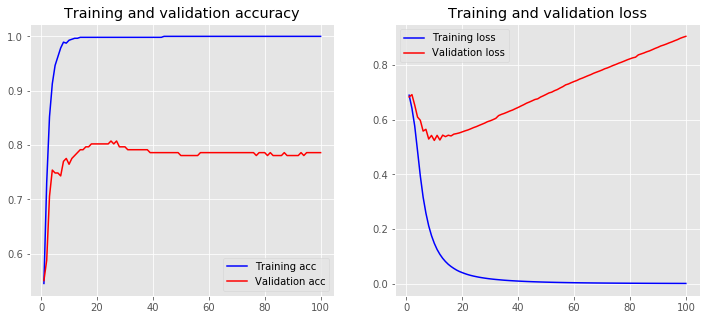

In [18]:
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

> Note: When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

This makes sure that you don't overfit the model. Using the validation set to choose the best model is a form of data leakage (or "cheating") to get to pick the result that produced the best test score out of hundreds of them. Data leakage happens when information outside the training data set is used in the model.

In this case, our testing and validation set are the same, since we have a smaller sample size. As we have covered before, (deep) neural networks perform best when you have a very large number of samples. In the next part, you'll see a different way to represent words as vectors. This is a very exciting and powerful way to work with words where you'll see how to represent words as dense vectors.

## What Is a Word Embedding?

Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data. In the previous BOW model, you have seen how to represent a whole sequence of words as a single feature vector. Now you will see how to represent each word as vectors. There are various ways to vectorize text, such as:

-   Words represented by each word as a vector
-   Characters represented by each character as a vector
-   N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)

In this tutorial, you'll see how to deal with representing words as vectors which is the common way to use text in neural networks. Two possible ways to represent a word as a vector are one-hot encoding and word embeddings.

### One-Hot Encoding

The first way to represent a word as a vector is by creating a so-called [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding, which is simply done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.

In this way, you have for each word, given it has a spot in the vocabulary, a vector with zeros everywhere except for the corresponding spot for the word which is set to one. As you might imagine, this can become a fairly large vector for each word and it does not give any additional information like the relationship between words.

Let's say you have a list of cities as in the following example:

In [19]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

You can use scikit-learn and the LabelEncoder to encode the list of cities into categorical integer values like here:

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

Using this representation, you can use the OneHotEncoder provided by scikit-learn to encode the categorical values we got before into a one-hot encoded numeric array. OneHotEncoder expects each categorical value to be in a separate row, so you’ll need to reshape the array, then you can apply the encoder:

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

You can see that categorical integer value represents the position of the array which is 1 and the rest is 0. This is often used when you have a categorical feature which you cannot represent as a numeric value but you still want to be able to use it in machine learning. One use case for this encoding is of course words in a text but it is most prominently used for categories. Such categories can be for example city, department, or other categories.

### Word Embeddings

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map [King - Man + Woman = Queen](https://www.technologyreview.com/s/541356/king-man-woman-queen-the-marvelous-mathematics-of-computational-linguistics/).

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for [text preprocessing](https://keras.io/preprocessing/text/) and [sequence preprocessing](https://keras.io/preprocessing/sequence/) which you can employ to prepare your text.

You can start by using the `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept. I have the testing and training data prepared from the previous example:

In [22]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


The indexing is ordered after the most common words in the text, which you can see by the word `the` having the index `1`. It is important to note that the index `0` is reserved and is not assigned to any word. This zero index is used for padding, which I'll introduce in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with `word_count + 1` since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object:

In [25]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27


KeyError: 'happy'

> Note: Pay close attention to the difference between this technique and the `X_train`that was produced by scikit-learn's `CountVectorizer`.

>With `CountVectorizer`, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don't denote counts, but rather correspond to the word values from the dictionary `tokenizer.word_index`.

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [26]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


The first values represent the index in the vocabulary as you have learned from the previous examples. You can also see that the resulting feature vector contains mostly zeros, since you have a fairly short sentence. In the next part you will see how to work with word embeddings in Keras.

### Keras Embedding Layer

Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the [Embedding Layer](https://keras.io/layers/embeddings/) of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

-   `input_dim`: the size of the vocabulary
-   `output_dim`: the size of the dense vector
-   `input_length`: the length of the sequence

With the `Embedding` layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a `Dense` layer. In order to do this you have to add a `Flatten` layer in between that prepares the sequential input for the `Dense` layer:

In [27]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 87350 new parameters to train. This number comes from `vocab_size` times the `embedding_dim`. These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors. You can train it with the following:

Training Accuracy: 1.0000
Testing Accuracy:  0.7166


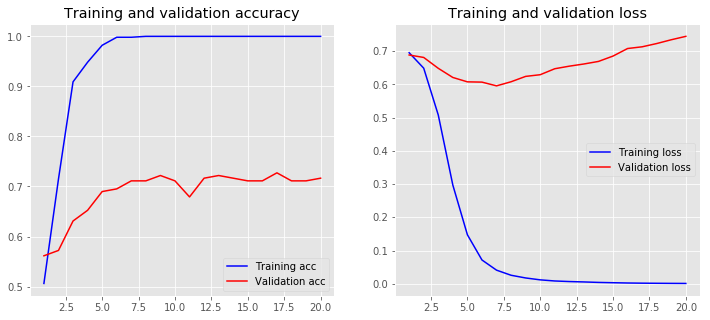

In [28]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a `MaxPooling1D`/`AveragePooling1D` or a `GlobalMaxPooling1D`/`GlobalAveragePooling1D` layer after the embedding. You can think of the pooling layers as a way to [downsample](https://en.wikipedia.org/wiki/Decimation_(signal_processing)) (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [29]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7914


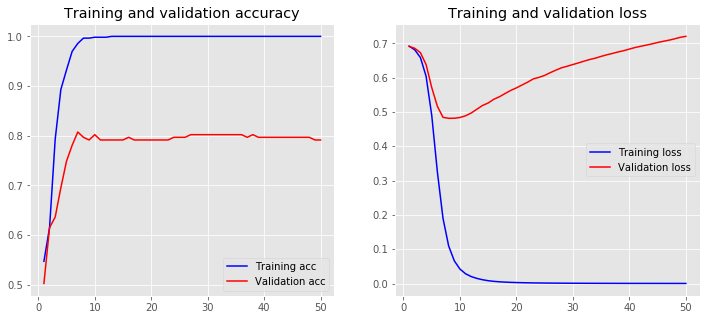

In [30]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can already see some improvements in our models. Next you'll see how we can employ pretrained word embeddings and if they help us with our model.

### Using Pretrained Word Embeddings

We just saw an example of jointly learning word embeddings incorporated into the larger model that we want to solve.

An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) developed by Google and [GloVe](https://nlp.stanford.edu/projects/glove/)(Global Vectors for Word Representation) developed by the Stanford NLP Group.

Note that those are different approaches with the same goal. Word2Vec achieves this by employing neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases you are dealing with dimensionality reduction, but Word2Vec is more accurate and GloVe is faster to compute.

In this tutorial, you'll see how to work with the GloVe word embeddings from the Stanford NLP Group as their size is more manageable than the Word2Vec word embeddings provided by Google. Go ahead and download the 6B (trained on 6 billion words) word embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB).

You can find other word embeddings also on the main [GloVe](https://nlp.stanford.edu/projects/glove/) page. You can find the pretrained Word2Vec embeddings by Google [here](https://code.google.com/archive/p/word2vec/). If you want to train your own word embeddings, you can do so efficiently with the [gensim](https://radimrehurek.com/gensim/index.html) Python package which uses Word2Vec for calculation. More details on how to do this [here](https://radimrehurek.com/gensim/models/word2vec.html).

Now that we got you covered, you can start using the word embeddings in your models. You can see in the next example how you can load the embedding matrix. Each line in the file starts with the word and is followed by the embedding vector for the particular word.

This is a large file with 400000 lines, with each line representing a word followed by its vector as a stream of floats. For example, here are the first 50 characters of the first line:

In [32]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [33]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
     'data/glove.6B/glove.6B.50d.txt',
     tokenizer.word_index, embedding_dim)

Wonderful! Now you are ready to use the embedding matrix in training. Let’s go ahead and use the previous network with global max pooling and see if we can improve this model. When you use pretrained word embeddings you have the choice to either allow the embedding to be updated during training or only use the resulting embedding vectors as they are.

First, let’s have a quick look how many of the embedding vectors are nonzero:


In [34]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

This means 95.1% of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary. Let’s have a look at the performance when using the GlobalMaxPool1D layer:

In [35]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7647
Testing Accuracy:  0.7433


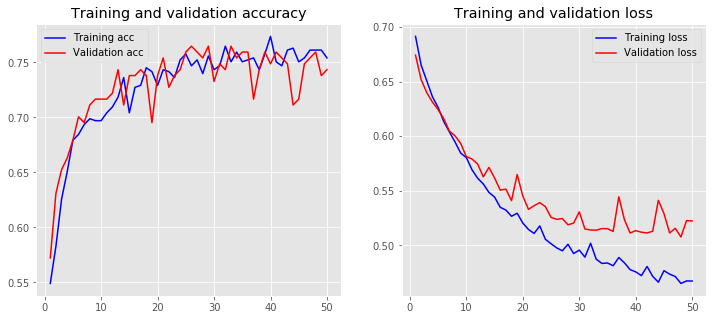

In [36]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [37]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8182


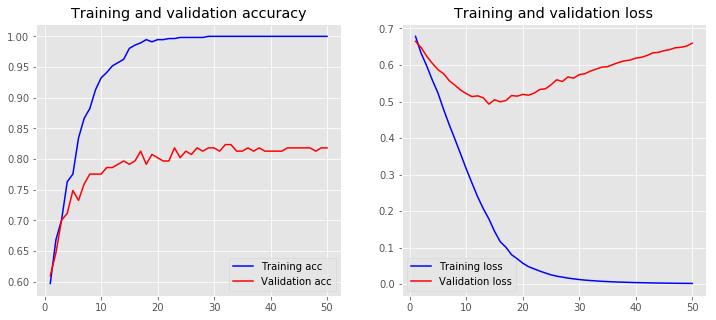

In [38]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that it is most effective to allow the embeddings to be trained. When dealing with large training sets it can boost the training process to be much faster than without. In our case it seemed to help but not by much. This does not have to be because of pretrained word embeddings.

Now it is time to focus on a more advanced neural network model to see if it is possible to boost the model and give it the leading edge over the previous models.

## Convolutional Neural Networks (CNN)

Convolutional neural networks or also called convnets are one of the most exciting developments in machine learning in recent years.

They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

If it is just another neural network, what differentiates it from what you have previously learned?

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

This is the very core of the technique, the mathematical process of [convolution](https://en.wikipedia.org/wiki/Convolution). With each convolutional layer the network is able to detect more complex patterns. In the [Feature Visualization](https://distill.pub/2017/feature-visualization/) by Chris Olah you can get a good intuition what these features can look like.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

In the next figure you can see how such a convolution works. It starts by taking a patch of input features with the size of the filter kernel. With this patch you take the dot product of the multiplied weights of the filter. The one dimensional convnet is invariant to translations, which means that certain sequences can be recognized at a different position. This can be helpful for certain patterns in the text:

[![one dimensional convolution](https://files.realpython.com/media/njanakiev-1d-convolution.d7afddde2776.png)](https://files.realpython.com/media/njanakiev-1d-convolution.d7afddde2776.png)

1D Convolution ([Image source](https://realpython.com/asins/1617294438/))

Now let's have a look how you can use this network in Keras. Keras offers again various [Convolutional layers](https://keras.io/layers/convolutional/) which you can use for this task. The layer you'll need is the `Conv1D`layer. This layer has again various parameters to choose from. The ones you are interested in for now are the number of filters, the kernel size, and the activation function. You can add this layer in between the `Embedding` layer and the `GlobalMaxPool1D` layer:

In [39]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7861


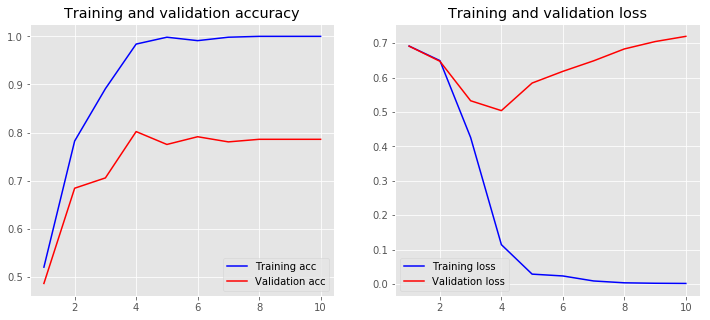

In [40]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:

-   There are not enough training samples
-   The data you have does not generalize well
-   Missing focus on tweaking the hyperparameters

CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won't be able.

## Hyperparameters Optimization

One crucial steps of deep learning and working with neural networks is [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

As you saw in the models that we have used so far, even with simpler ones, you had a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning and sadly there are no one-fits-all solutions ready.

When you have a look at the competitions on [Kaggle](http://kaggle.com/), one of the largest places to compete against other fellow data scientists, you can see that many of the winning teams and models have gone through a lot of tweaking and experimenting until they reached their prime. So don't get discouraged when it gets tough and you reach a plateau, but rather think about the ways you could optimize the model or the data.

One popular method for hyperparameter optimization is [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search). What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you'll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, you will need to use the [KerasClassifier](https://keras.io/scikit-learn-api/) which serves as a wrapper for the [scikit-learn API](http://scikit-learn.org/). With this wrapper you are able to use the various tools available with scikit-learn like [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html). The class that you need is [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets.

There are various types of cross-validation. One type is the k-fold cross-validation which you'll see in this example. In this type the data set is partitioned into *k* equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables you to run *k* different runs, where each partition is once used as a testing set. So, the higher *k* is the more accurate the model evaluation is, but the smaller each testing set is.

First step for `KerasClassifier` is to have a function that creates a Keras model. We will use the previous model, but we will allow various parameters to be set for the hyperparameter optimization:

In [41]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Next, you want to define the parameter grid that you want to use in training. This consists of a dictionary with each parameters named as in the previous function. The number of spaces on the grid is 3 * 3 * 1 * 1 * 1, where each of those numbers is the number of different choices for a given parameter.

You can see how this could get computationally expensive very quickly, but luckily both grid search and random search are embarrassingly parallel, and the classes come with an n_jobs parameter that lets you test grid spaces in parallel. The parameter grid is initialized with the following dictionary:

In [42]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

Now you are already ready to start running the random search. In this example we iterate over each data set and then you want to preprocess the data in the same way as previously. Afterwards you take the previous function and add it to the `KerasClassifier` wrapper class including the number of epochs.

The resulting instance and the parameter grid are then used as the estimator in the `RandomSearchCV` class. Additionally, you can choose the number of folds in the k-folds cross-validation, which is in this case 4. You have seen most of the code in this snippet before in our previous examples. Besides the `RandomSearchCV` and `KerasClassifier`, I have added a little block of code handling the evaluation:

In [43]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.5min finished


finished amazon; write to file and proceed? [y/n]y
Running amazon data set
Best Accuracy : 0.8161
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8443


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 70.5min finished


finished imdb; write to file and proceed? [y/n]y
Running imdb data set
Best Accuracy : 0.8205
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8530


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.8min finished


finished yelp; write to file and proceed? [y/n]y
Running yelp data set
Best Accuracy : 0.8190
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8472




This takes a while which is a perfect chance to go outside to get some fresh air or even go on a hike, depending on how many models you want to run. Let’s take a look what we have got:

Interesting! For some reason the testing accuracy is higher than the training accuracy which might be because there is a large variance in the scores during cross-validation. We can see that we were still not able to break much through the dreaded 80%, which seems to be a natural limit for this data with its given size. Remember that we have a small data set and convolutional neural networks tend to perform the best with large data sets.

Another method for CV is the nested cross-validation (shown [here](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html#grid-search)) which is used when the hyperparameters also need to be optimized. This is used because the resulting non-nested CV model has a bias toward the data set which can lead to an overly optimistic score. You see, when doing hyperparameter optimization as we did in the previous example, we are picking the best hyperparameters for that specific training set but this does not mean that these hyperparameters generalize the best.

## Conclusion

There you have it: you have learned how to work with text classification with Keras, and we have gone from a bag-of-words model with logistic regression to increasingly more advanced methods leading to convolutional neural networks.

You should be now familiar with word embeddings, why they are useful, and also how to use pretrained word embeddings for your training. You have also learned how to work with neural networks and how to use hyperparameter optimization to squeeze more performance out of your model.

One big topic which we have not covered here left for another time was [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), more specifically [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) and [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit). Those are other powerful and popular tools to work with sequential data like text or time series. Other interesting developments are currently in neural networks that employ [attention](https://distill.pub/2016/augmented-rnns/) which are under active research and seem to be a promising next step since LSTM tend to be heavy on the computation.

You have now an understanding of a crucial cornerstone in natural language processing which you can use for text classification of all sorts. Sentiment analysis is the most prominent example for this, but this includes many other applications such as:

-   Spam detection in emails
-   Automatic tagging of texts
-   Categorization of news articles with predefined topics

You can use this knowledge and the models that you have trained on an advanced project as in this [tutorial](https://realpython.com/twitter-sentiment-python-docker-elasticsearch-kibana/) to employ sentiment analysis on a continuous stream of twitter data with Kibana and Elasticsearch. You could also combine sentiment analysis or text classification with speech recognition like in this handy [tutorial](https://realpython.com/python-speech-recognition/) using the SpeechRecognition library in Python.